<a href="https://colab.research.google.com/github/RonChits/Titanic/blob/main/titanic_survivors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic survivors.

> Problem statement: “What sorts of people were more likely to survive?”

## Modules.

In [ ]:
import pandas as pd
import numpy as np
import re
import xgboost
import category_encoders as ce
import seaborn as sns
import string
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Sampling techniques.
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Classifiers.
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier

# Transformers.
from sklearn.preprocessing import StandardScaler,  OneHotEncoder, LabelEncoder, FunctionTransformer

# Metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, ConfusionMatrixDisplay,precision_score, f1_score, roc_curve , auc, confusion_matrix
from sklearn.pipeline import Pipeline, make_pipeline

>My Data.

In [ ]:
gender = pd.read_csv("gender_submission.csv", index_col = 0)

In [ ]:
train = pd.read_csv("train.csv", index_col = 0)

In [ ]:
test = pd.read_csv("test.csv", index_col = 0)

In [ ]:
train.shape

(891, 11)

In [ ]:
test.shape

(418, 10)

In [ ]:
df = pd.concat([train, test])

In [ ]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
df.shape

(1309, 11)

### Gender

In [ ]:
gender.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Survived  418 non-null    int64
dtypes: int64(1)
memory usage: 6.5 KB


In [ ]:
gender.head()

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1


In [ ]:
gender.shape

(418, 1)

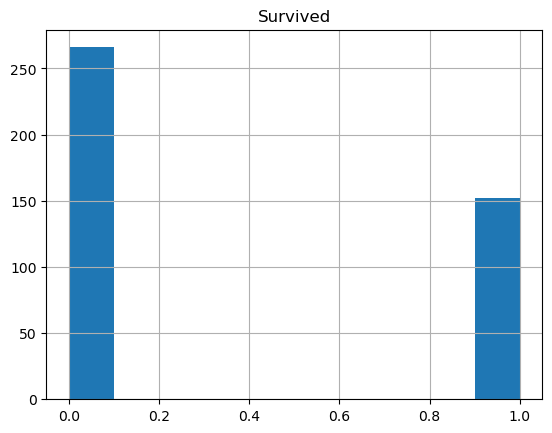

In [ ]:
gender.hist()
plt.show()

> Is there any missing values?

In [ ]:
gender.isnull().sum()

Survived    0
dtype: int64

>Imbalance checking.

In [ ]:
gender['Survived'].value_counts()

0    266
1    152
Name: Survived, dtype: int64

## Train set

In [ ]:
train.shape

(891, 11)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [ ]:
train.head(-5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
882,0,3,"Markun, Mr. Johann",male,33.0,0,0,349257,7.8958,NaN,S
883,0,3,"Dahlberg, Miss. Gerda Ulrika",female,22.0,0,0,7552,10.5167,NaN,S
884,0,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S


In [ ]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [ ]:
train.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

> Cabin is showing a large part that has missing values, and this pose a big problem as to use this feature.

In [ ]:
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


>

* Distribution on dataset to train the model.

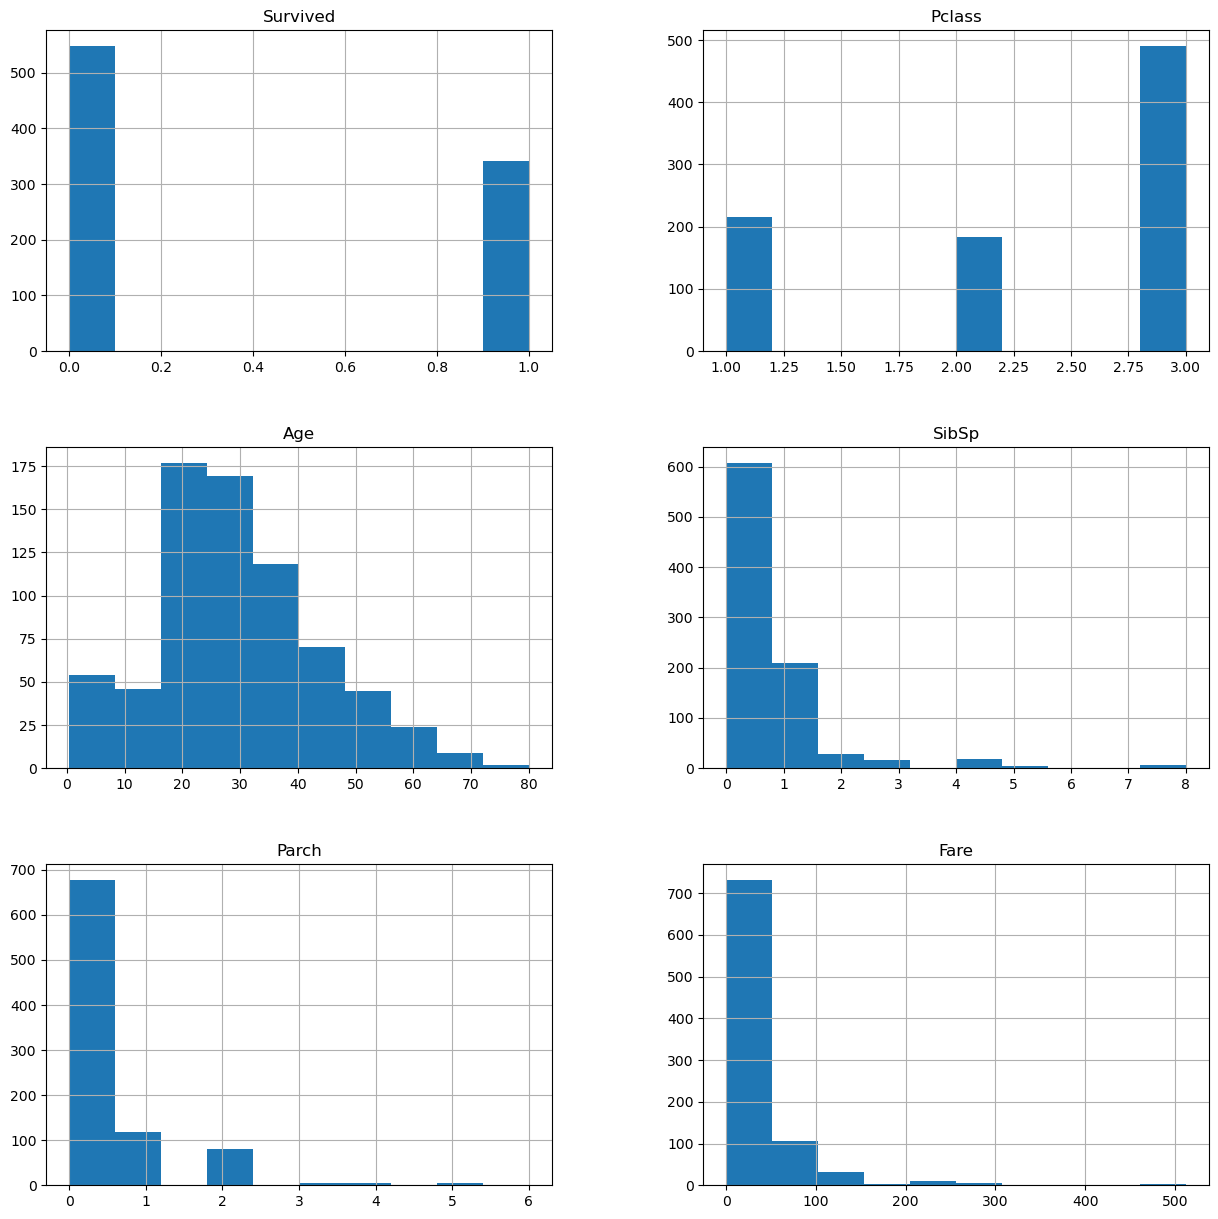

In [ ]:
train.hist(figsize=(15, 15))
plt.show()

>

* Correlation between features is tested to avoid the bias in model training.

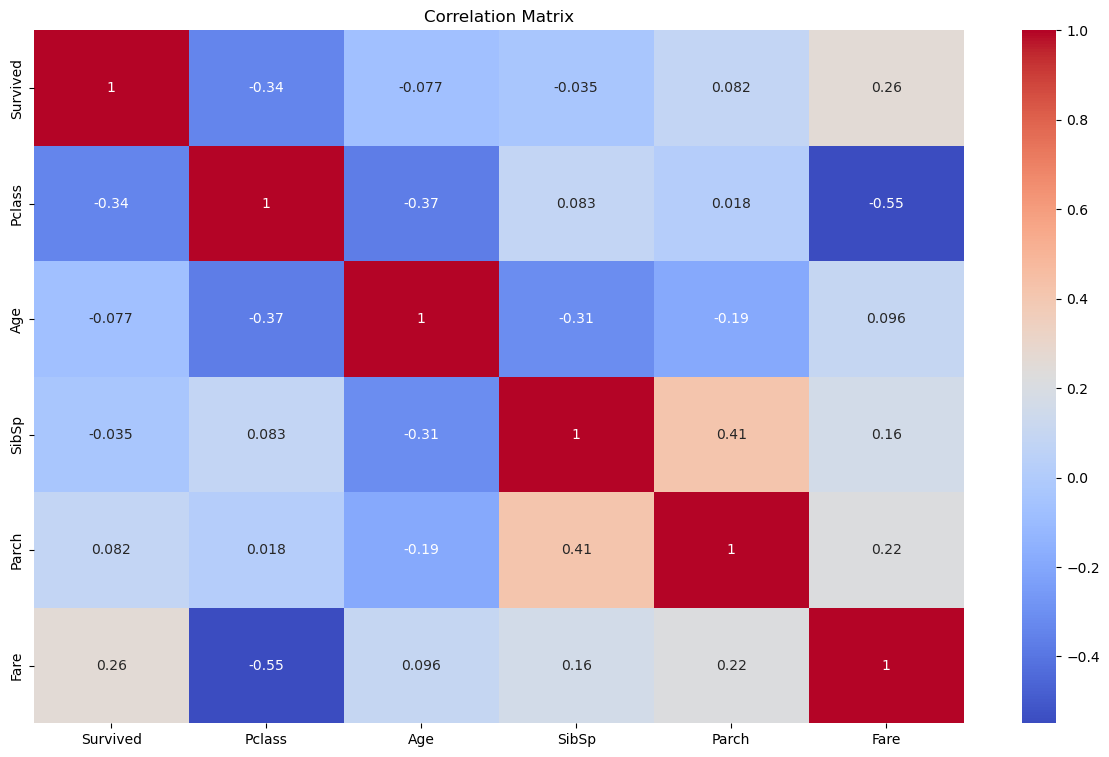

In [ ]:
dfg = ["Survived", "Pclass", "Age", "SibSp", "Parch","Fare"]
corr_matrix = train[dfg].corr()

# Create heatmap
plt.figure(figsize=(15, 9))  # Adjust figure size as needed
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

* Some information about gender, so as to have clear observation as this may be a fact that females are considered vulnerable. And this leads to more females and children to survive.

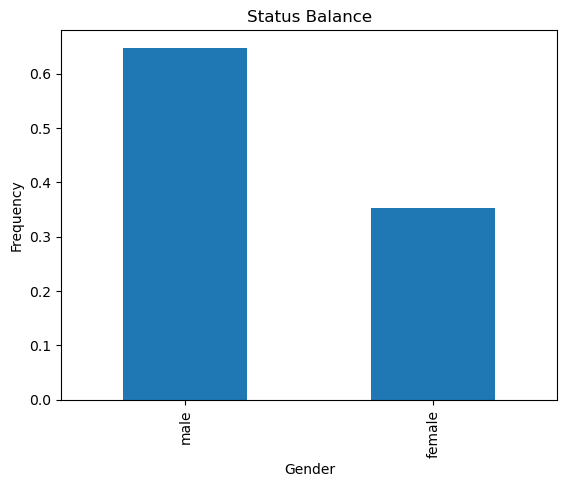

In [ ]:
# Plot class balance
train["Sex"].value_counts(normalize=True).plot(
    kind="bar",
    xlabel="Gender",
    ylabel="Frequency",
    title="Status Balance"
);

In [ ]:
data2 = pd.crosstab(
    index=train["Survived"],
    columns=df["Sex"],
    normalize=False
)

print("data type:", type(data2))
print("data shape:", data2.shape)
data2

data type: <class 'pandas.core.frame.DataFrame'>
data shape: (2, 2)


Sex,female,male
Survived,,
0,81,468
1,233,109


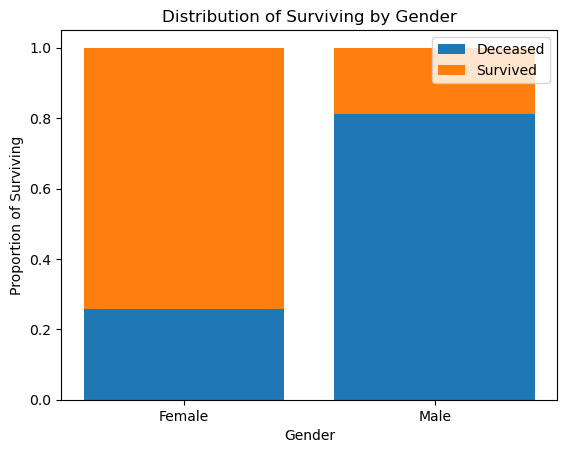

In [ ]:
# Distribution of Surviving by Gender

deceased = [data2['female'][1] / (data2['female'][0] + data2['female'][1]),
             data2['male'][1] / (data2['male'][0] + data2['male'][1])]
survived = [1 - deceased[0], 1 - deceased[1]]

labels = ['Female', 'Male']

plt.bar(labels, survived, label='Deceased')
plt.bar(labels, deceased, bottom=survived, label='Survived')

plt.xlabel('Gender')
plt.ylabel('Proportion of Surviving')
plt.title('Distribution of Surviving by Gender')
_ = plt.legend()


* From above by proportion males who died where more than females. And lets look into males with age.

In [ ]:
males = train[train['Sex'] == 'male']
males_under15 = males[males['Age'] < 15]
males_over15 = males[males['Age'] > 15]
dt = pd.crosstab(
    index=males_under15["Survived"],
    columns=df["Sex"],
    normalize=False
)
t = pd.crosstab(
    index=males_over15["Survived"],
    columns=df["Sex"],
    normalize=False
)

dtt = pd.concat([t, dt])
dtt

Sex,male
Survived,
0,341
1,72
0,18
1,21


* And from above we are seeing a big difference as man are older than 15 chance of surving was low, lets visualise the relationship.

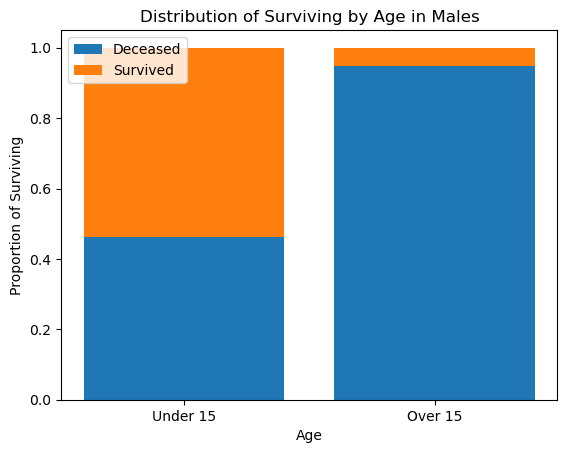

In [ ]:
# Distribution of Surviving by Age in Males.

deceased = [dt['male'][1] / (dt['male'][0] + dt['male'][1]),
             dt['male'][1] / (t['male'][0] + t['male'][1])]
survived = [1 - deceased[0], 1 - deceased[1]]

labels = ['Under 15', 'Over 15']

plt.bar(labels, survived, label='Deceased')
plt.bar(labels, deceased, bottom=survived, label='Survived')

plt.xlabel('Age')
plt.ylabel('Proportion of Surviving')
plt.title('Distribution of Surviving by Age in Males')
_ = plt.legend()

* Incredible insight right?

>

* Lets look into females does age matter to their surviving?

In [ ]:
females = train[train['Sex'] == 'female']
females_under15 = females[females['Age'] < 15]
females_over15 = females[females['Age'] > 15]
ft = pd.crosstab(
    index=females_under15["Survived"],
    columns=df["Sex"],
    normalize=False
)
e = pd.crosstab(
    index=females_over15["Survived"],
    columns=df["Sex"],
    normalize=False
)

fte = pd.concat([ft, e])
fte

Sex,female
Survived,
0,15
1,24
0,49
1,169


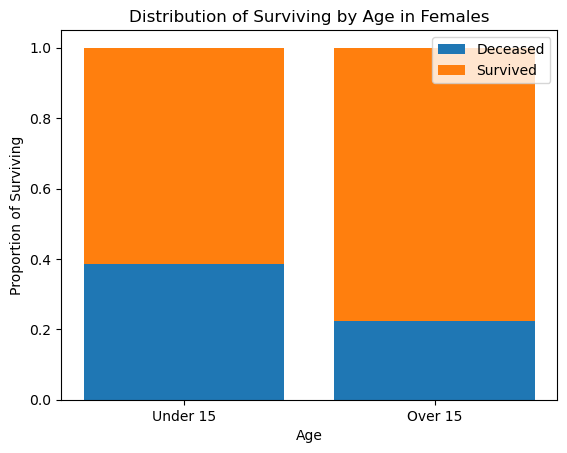

In [ ]:
# Distribution of Surviving by Age in females.

deceasedf = [ft['female'][1] / (ft['female'][0] + ft['female'][1]),
             e['female'][1] / (e['female'][0] + e['female'][1])]
survivedf = [1 - deceasedf[0], 1 - deceasedf[1]]

labels = ['Under 15', 'Over 15']

plt.bar(labels, survivedf, label='Deceased')
plt.bar(labels, deceasedf, bottom=survivedf, label='Survived')

plt.xlabel('Age')
plt.ylabel('Proportion of Surviving')
plt.title('Distribution of Surviving by Age in Females')
_ = plt.legend()

* Generally females survived more proportinaly to their age groups, though here we see an anormaly over 15 yrs woman survived more than under 15, the case may be on "saving yourself first" scenario, leading to young girls failing to sieze opportunities to be first out of the ship.

>

> Looking into dataset to train the model.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Name      1309 non-null   object 
 3   Sex       1309 non-null   object 
 4   Age       1046 non-null   float64
 5   SibSp     1309 non-null   int64  
 6   Parch     1309 non-null   int64  
 7   Ticket    1309 non-null   object 
 8   Fare      1308 non-null   float64
 9   Cabin     295 non-null    object 
 10  Embarked  1307 non-null   object 
dtypes: float64(3), int64(3), object(5)
memory usage: 155.0+ KB


In [ ]:
d = ['Name', 'Cabin']
X = df.drop(d, axis=1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.319327731092, shuffle=False)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (891, 9)
y_train shape: (891,)
X_test shape: (418, 9)
y_test shape: (418,)


In [ ]:
label_encoder = LabelEncoder()
X_train.dropna(inplace=True)
for col in ["Sex","Ticket","Embarked"]:
    X_train[col] = label_encoder.fit_transform(X_train[col])

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 1 to 891
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  712 non-null    float64
 1   Pclass    712 non-null    int64  
 2   Sex       712 non-null    int32  
 3   Age       712 non-null    float64
 4   SibSp     712 non-null    int64  
 5   Parch     712 non-null    int64  
 6   Ticket    712 non-null    int32  
 7   Fare      712 non-null    float64
 8   Embarked  712 non-null    int32  
dtypes: float64(3), int32(3), int64(3)
memory usage: 47.3 KB


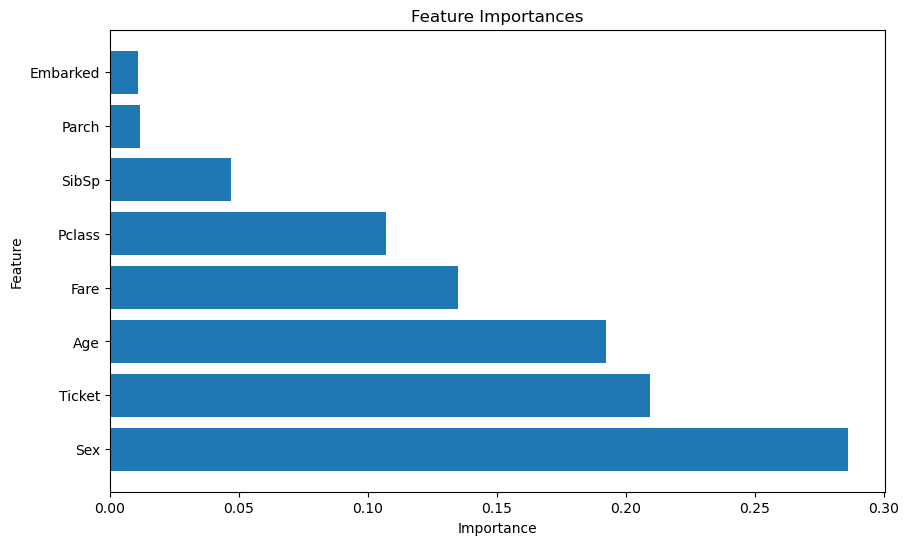

In [ ]:
from sklearn.ensemble import RandomForestRegressor
X1 = X_train.drop(['Survived'], axis=1)  # Features
y1 = X_train['Survived']  # Target variable
# 'X' contains our features and 'y' is our target variable
model = RandomForestRegressor()
model.fit(X1, y1)

importances = model.feature_importances_
feature_importances_df = pd.DataFrame({'Feature': X1.columns, 'Importance': importances})
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

In [ ]:
feature_importances_df.head(8)

,Feature,Importance
1,Sex,0.286179
5,Ticket,0.209576
2,Age,0.192223
6,Fare,0.134844
0,Pclass,0.107240
3,SibSp,0.047048
4,Parch,0.011756
7,Embarked,0.011134


> All features tend to be important on this feature importance above

## Test set

> Categorical features.
* label encoder changes the category to numerical representation.

In [ ]:
label_encoder = LabelEncoder()
for col in ["Sex","Ticket","Embarked"]:
    X_test[col] = label_encoder.fit_transform(X_test[col])

In [ ]:
X_test = X_test.drop(['Survived'], axis=1)
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,
892,3,1,34.5,0,0,152,7.8292,1
893,3,0,47.0,1,0,221,7.0000,2
894,2,1,62.0,0,0,73,9.6875,1
895,3,1,27.0,0,0,147,8.6625,2
896,3,0,22.0,1,1,138,12.2875,2


> Dealing with Data imbalance

In [ ]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X1, y1)
print("X_train_over shape:", X_train_over.shape)

X_train_over shape: (848, 8)


* Checking if data imbalance is corrected( equal class presentation)

In [ ]:
import collections

# Count class occurrences
counter = collections.Counter(y_train_over)
print(counter)

Counter({0.0: 424, 1.0: 424})


## Scaling

* Data is scaled to avoid overcomplexity to the model by big different data range. This scaler fits data between 0-1

In [ ]:
scaler = StandardScaler()
# Fit and transform the training data
X_train_scaled_over = pd.DataFrame(scaler.fit_transform(X_train_over), columns=X_train_over.columns)
#  Data NOT Resampled
X_scaled = pd.DataFrame(scaler.fit_transform(X1), columns=X1.columns)

In [ ]:
scaler = StandardScaler()
# Transform the test data using the same scaler
X_test_scaled_over = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

In [ ]:
c =['Survived']
y_test = pd.DataFrame(gender[c])

In [ ]:
y_test.head(5)

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1


 > Checking data shapes.
 >

In [ ]:
X_test_scaled_over.shape

(418, 8)

In [ ]:
X_scaled.shape

(712, 8)

In [ ]:
y_test.shape

(418, 1)

In [ ]:
gender.shape

(418, 1)

In [ ]:
X_test.shape

(418, 8)

# Model Building.

In [ ]:
majority_class = y.mode()[0]
baseline_accuracy = (y_train_over == majority_class).mean()
print("Baseline Accuracy:", baseline_accuracy)

Baseline Accuracy: 0.5


## a) XGBoostClassifier.

In [ ]:
import os
os.environ["XLA_FLAGS"] = "--xla_cpu_multi_thread_eigen=false intra_op_parallelism_threads=1"
# oversampled data model.
pipe = Pipeline([
    ('scaling', FunctionTransformer(lambda x:x)),
    ('xgboost', XGBClassifier(objective= 'binary:logistic'))
])

parameters = {'xgboost__max_depth': [400],
              'xgboost__n_estimators' : [100, 200],
              'xgboost__learning_rate' : [0.001],
              'xgboost__tree_method': ['exact', 'approx', 'hist'],
              'xgboost__min_child_weight': [2],
              'xgboost__gamma': [4]
              }


gs = GridSearchCV(pipe, parameters, cv=10, scoring='roc_auc', n_jobs=-1, verbose=10)

gs.fit(X_train_over, y_train_over)

best_model = gs.best_estimator_
y_test_proba = best_model.predict_proba(X_test_scaled_over)
y_pred = best_model.predict(X_test_scaled_over)
accuracy = accuracy_score(gender['Survived'], y_pred)
print('LR ROC AUC:', roc_auc_score(gender['Survived'], y_test_proba[:, 1]))
print(f"Accuracy: {accuracy:.4f}")

Fitting 10 folds for each of 6 candidates, totalling 60 fits
LR ROC AUC: 1.0
Accuracy: 1.0000


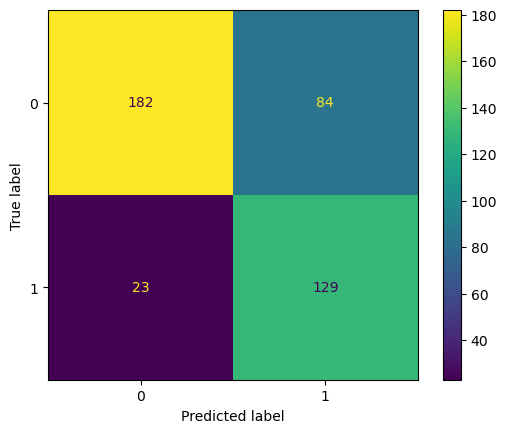

In [ ]:
ConfusionMatrixDisplay.from_estimator(best_model, X_test, gender['Survived'])

(0.0, 1.05)

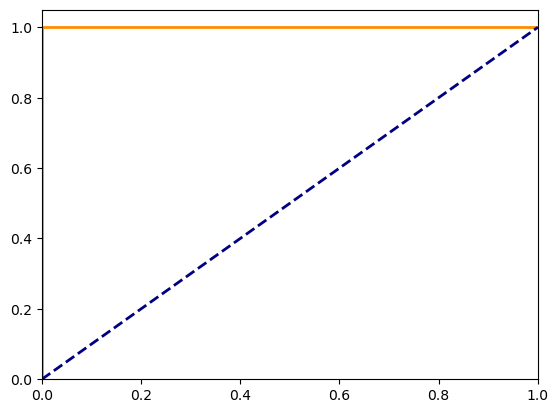

In [ ]:
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilities of class 1
fpr, tpr, thresholds = roc_curve(gender['Survived'], y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

In [ ]:
# Get the confusion matrix
cm = confusion_matrix(y_test, best_model.predict(X_test))

# True Positives (TP)
TP = cm[0][0]

# True Negatives (TN)
TN = cm[1][1]

# False Positives (FP)
FP = cm[0][1]

# False Negatives (FN)
FN = cm[1][0]

# Calculate precision
precision = TP / (TP + FP)

# Calculate F1 score
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print results
print("Precision:", precision)
print("F1 Score:", f1_score)

Precision: 0.6842105263157895
F1 Score: 0.772823779193206


In [ ]:
output = pd.DataFrame({'PassengerId': y_test.index, 'Survived': y_pred})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [ ]:
sub = pd.read_csv("submission.csv")

In [ ]:
sub.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
